In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow import keras

In [4]:
train = pd.read_csv("/content/drive/MyDrive/petfinder-pawpularity-score/train.csv")
test = pd.read_csv("/content/drive/MyDrive/petfinder-pawpularity-score/test.csv")
sample_submission = pd.read_csv("/content/drive/MyDrive/petfinder-pawpularity-score/sample_submission.csv")

In [5]:
train["file_path"] = train["Id"].apply(lambda identifier: "/content/drive/MyDrive/petfinder-pawpularity-score/train/" + identifier + ".jpg")
test["file_path"] = test["Id"].apply(lambda identifier: "/content/drive/MyDrive/petfinder-pawpularity-score/test/" + identifier + ".jpg")

In [6]:
tabular_columns = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']
image_size = 224
batch_size = 128
epochs = 100
train_on_fold = None # Which Fold to train, train on all folds if None
AUTO = tf.data.experimental.AUTOTUNE

In [7]:
def random_erasing(img, sl=0.1, sh=0.2, rl=0.4, p=0.3):
    h = tf.shape(img)[0]
    w = tf.shape(img)[1]
    c = tf.shape(img)[2]
    origin_area = tf.cast(h*w, tf.float32)

    e_size_l = tf.cast(tf.round(tf.sqrt(origin_area * sl * rl)), tf.int32)
    e_size_h = tf.cast(tf.round(tf.sqrt(origin_area * sh / rl)), tf.int32)

    e_height_h = tf.minimum(e_size_h, h)
    e_width_h = tf.minimum(e_size_h, w)

    erase_height = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_height_h, dtype=tf.int32)
    erase_width = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_width_h, dtype=tf.int32)

    erase_area = tf.zeros(shape=[erase_height, erase_width, c])
    erase_area = tf.cast(erase_area, tf.uint8)

    pad_h = h - erase_height
    pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
    pad_bottom = pad_h - pad_top

    pad_w = w - erase_width
    pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
    pad_right = pad_w - pad_left

    erase_mask = tf.pad([erase_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
    erase_mask = tf.squeeze(erase_mask, axis=0)
    erased_img = tf.multiply(tf.cast(img,tf.float32), tf.cast(erase_mask, tf.float32))

    return tf.cond(tf.random.uniform([], 0, 1) > p, lambda: tf.cast(img, img.dtype), lambda:  tf.cast(erased_img, img.dtype))

In [8]:
def data_augment(image):
    image = tf.image.random_flip_left_right(image)
    image = random_erasing(image)
    return image

In [9]:
def preprocess_training(image_url, tabular):
    image_string = tf.io.read_file(image_url)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = data_augment(image)
    image = tf.image.central_crop(image, 1.0)
    image = tf.image.resize(image, (image_size, image_size))
    return (image, tabular[1:]), tf.cast(tabular[0], tf.float32)

def preprocess_validation(image_url, tabular):
    image_string = tf.io.read_file(image_url)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.central_crop(image, 1.0)
    image = tf.image.resize(image, (image_size, image_size))
    return (image, tabular[1:]), tf.cast(tabular[0], tf.float32)

In [10]:
def base_model():
    efficient_net = tf.keras.applications.EfficientNetB0(
        weights = "/content/drive/MyDrive/efficientnetb0_notop.h5", 
        include_top = False, 
        input_shape = (image_size, image_size, 3)
    )    
    efficient_net.trainable = False
    return efficient_net

In [11]:
efficient_net = base_model()

In [12]:
def get_tabular_model(inputs):
    width = 32
    depth = 3
    activation = "relu"
    kernel_regularizer = keras.regularizers.l2()
    x = keras.layers.Dense(
            width, 
            activation=activation,
            kernel_regularizer=kernel_regularizer
        )(inputs)
    for i in range(depth):
        if i == 0:
            x = inputs
        x = keras.layers.Dense(
            width, 
            activation=activation,
            kernel_regularizer=kernel_regularizer
        )(x)
        if (i + 1) % 3 == 0:
            x = keras.layers.Concatenate()([x, inputs])
    return x

In [21]:
def get_model():
    image_inputs = tf.keras.Input((image_size, image_size , 3))
    tabular_inputs = tf.keras.Input(len(tabular_columns))
    # image_x = efficient_net(image_inputs)
    # image_x = tf.keras.layers.GlobalAveragePooling2D()(image_x)
    #for _ in range(1):
    #    image_x = tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2())(image_x)
    # image_x = tf.keras.layers.Dropout(0.5)(image_x)
    tabular_x = get_tabular_model(tabular_inputs)
    # x = tf.keras.layers.Concatenate(axis=1)([image_x, tabular_x])
    output = tf.keras.layers.Dense(1)(tabular_x)
    model = tf.keras.Model(inputs=[image_inputs, tabular_inputs], outputs=[output])
    return model

In [22]:
show_architecture = False
if show_architecture:
    model = get_model()
    tf.keras.utils.plot_model(model, show_shapes=True)
    print(model.summary())
    image = np.random.normal(size=(1, image_size, image_size, 3))
    tabular = np.random.normal(size=(1, len(tabular_columns)))
    print(image.shape, tabular.shape)
    print(model((image, tabular)).shape)

Epoch 1/100
62/62 [==============================] - 2362s 35s/step - loss: 1625.2648 - rmse: 40.3042 - val_loss: 1163.1158 - val_rmse: 34.0915 - lr: 0.0010
Epoch 2/100
62/62 [==============================] - 0s 3ms/step - loss: 624.7542 - rmse: 24.9757 - val_loss: 501.5338 - val_rmse: 22.3732 - lr: 0.0010
Epoch 3/100
62/62 [==============================] - 0s 2ms/step - loss: 471.8524 - rmse: 21.7000 - val_loss: 482.4875 - val_rmse: 21.9438 - lr: 0.0010
Epoch 4/100
62/62 [==============================] - 0s 3ms/step - loss: 457.5258 - rmse: 21.3676 - val_loss: 472.0334 - val_rmse: 21.7044 - lr: 0.0010
Epoch 5/100
62/62 [==============================] - 0s 3ms/step - loss: 448.0638 - rmse: 21.1449 - val_loss: 464.1103 - val_rmse: 21.5209 - lr: 0.0010
Epoch 6/100
62/62 [==============================] - 0s 2ms/step - loss: 440.4764 - rmse: 20.9645 - val_loss: 457.4451 - val_rmse: 21.3652 - lr: 0.0010
Epoch 7/100
62/62 [==============================] - 0s 3ms/step - loss: 434.2549 -

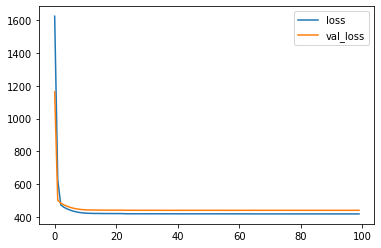

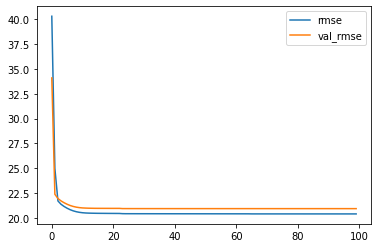

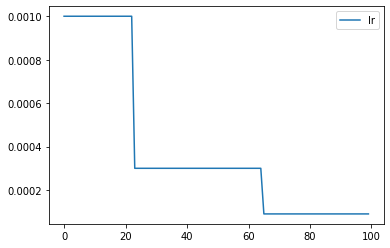

Epoch 1/100
62/62 [==============================] - 393s 6s/step - loss: 1680.6848 - rmse: 40.9863 - val_loss: 1207.2841 - val_rmse: 34.7339 - lr: 0.0010
Epoch 2/100
62/62 [==============================] - 0s 3ms/step - loss: 669.7516 - rmse: 25.8618 - val_loss: 480.1267 - val_rmse: 21.8904 - lr: 0.0010
Epoch 3/100
62/62 [==============================] - 0s 3ms/step - loss: 480.1576 - rmse: 21.8914 - val_loss: 463.1237 - val_rmse: 21.4990 - lr: 0.0010
Epoch 4/100
62/62 [==============================] - 0s 3ms/step - loss: 466.0339 - rmse: 21.5665 - val_loss: 450.6375 - val_rmse: 21.2065 - lr: 0.0010
Epoch 5/100
62/62 [==============================] - 0s 3ms/step - loss: 455.4394 - rmse: 21.3192 - val_loss: 438.0503 - val_rmse: 20.9071 - lr: 0.0010
Epoch 6/100
62/62 [==============================] - 0s 3ms/step - loss: 444.8925 - rmse: 21.0697 - val_loss: 425.7735 - val_rmse: 20.6105 - lr: 0.0010
Epoch 7/100
62/62 [==============================] - 0s 3ms/step - loss: 437.2643 - r

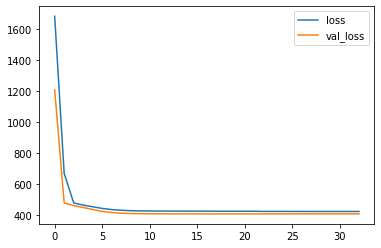

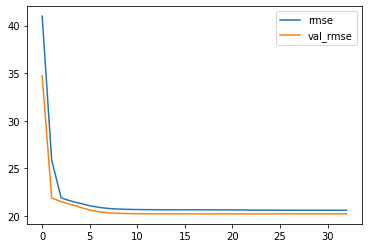

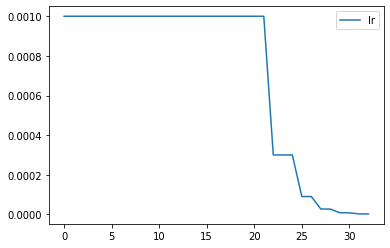

Epoch 1/100
62/62 [==============================] - 275s 4s/step - loss: 1745.6223 - rmse: 41.7714 - val_loss: 1534.0092 - val_rmse: 39.1565 - lr: 0.0010
Epoch 2/100
62/62 [==============================] - 0s 2ms/step - loss: 871.8450 - rmse: 29.5126 - val_loss: 495.7406 - val_rmse: 22.2447 - lr: 0.0010
Epoch 3/100
62/62 [==============================] - 0s 3ms/step - loss: 486.5709 - rmse: 22.0381 - val_loss: 452.5129 - val_rmse: 21.2515 - lr: 0.0010
Epoch 4/100
62/62 [==============================] - 0s 3ms/step - loss: 459.8576 - rmse: 21.4235 - val_loss: 437.6056 - val_rmse: 20.8975 - lr: 0.0010
Epoch 5/100
62/62 [==============================] - 0s 3ms/step - loss: 445.5702 - rmse: 21.0870 - val_loss: 429.3058 - val_rmse: 20.6974 - lr: 0.0010
Epoch 6/100
62/62 [==============================] - 0s 3ms/step - loss: 435.9654 - rmse: 20.8573 - val_loss: 425.0520 - val_rmse: 20.5938 - lr: 0.0010
Epoch 7/100
62/62 [==============================] - 0s 3ms/step - loss: 430.3329 - r

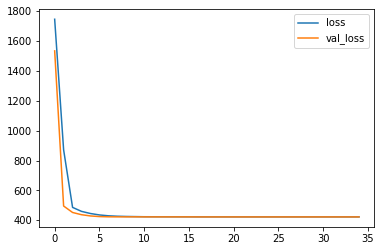

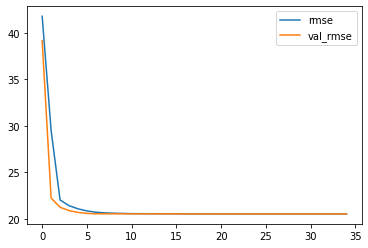

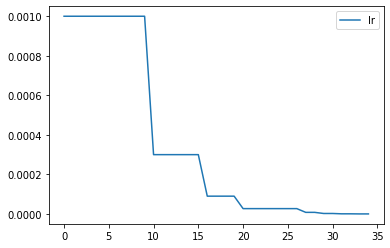

Epoch 1/100
62/62 [==============================] - 465s 7s/step - loss: 1676.6591 - rmse: 40.9371 - val_loss: 1377.7787 - val_rmse: 37.1072 - lr: 0.0010
Epoch 2/100
62/62 [==============================] - 0s 5ms/step - loss: 746.0736 - rmse: 27.2973 - val_loss: 490.4248 - val_rmse: 22.1233 - lr: 0.0010
Epoch 3/100
62/62 [==============================] - 0s 5ms/step - loss: 464.8391 - rmse: 21.5375 - val_loss: 470.9933 - val_rmse: 21.6796 - lr: 0.0010
Epoch 4/100
62/62 [==============================] - 0s 6ms/step - loss: 449.2857 - rmse: 21.1727 - val_loss: 456.1594 - val_rmse: 21.3338 - lr: 0.0010
Epoch 5/100
62/62 [==============================] - 1s 21ms/step - loss: 435.6366 - rmse: 20.8467 - val_loss: 446.2201 - val_rmse: 21.0983 - lr: 0.0010
Epoch 6/100
62/62 [==============================] - 0s 7ms/step - loss: 427.9510 - rmse: 20.6604 - val_loss: 441.9417 - val_rmse: 20.9958 - lr: 0.0010
Epoch 7/100
62/62 [==============================] - 0s 4ms/step - loss: 424.5514 - 

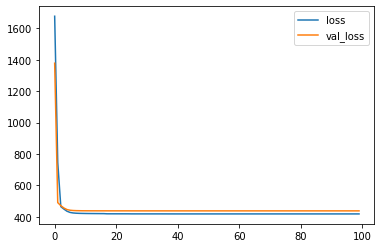

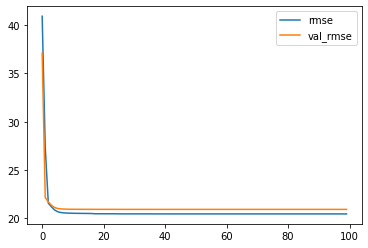

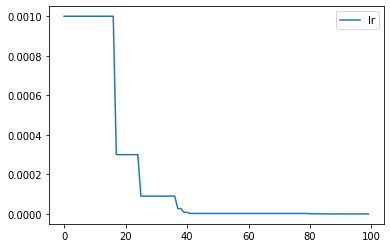

Epoch 1/100
62/62 [==============================] - 455s 7s/step - loss: 1657.9574 - rmse: 40.7080 - val_loss: 1244.4592 - val_rmse: 35.2649 - lr: 0.0010
Epoch 2/100
62/62 [==============================] - 0s 3ms/step - loss: 699.5872 - rmse: 26.4320 - val_loss: 493.8176 - val_rmse: 22.2004 - lr: 0.0010
Epoch 3/100
62/62 [==============================] - 0s 3ms/step - loss: 480.2240 - rmse: 21.8922 - val_loss: 460.0309 - val_rmse: 21.4260 - lr: 0.0010
Epoch 4/100
62/62 [==============================] - 0s 3ms/step - loss: 459.3118 - rmse: 21.4089 - val_loss: 444.3224 - val_rmse: 21.0557 - lr: 0.0010
Epoch 5/100
62/62 [==============================] - 0s 2ms/step - loss: 448.2701 - rmse: 21.1490 - val_loss: 435.1006 - val_rmse: 20.8350 - lr: 0.0010
Epoch 6/100
62/62 [==============================] - 0s 3ms/step - loss: 440.3439 - rmse: 20.9601 - val_loss: 428.7460 - val_rmse: 20.6814 - lr: 0.0010
Epoch 7/100
62/62 [==============================] - 0s 3ms/step - loss: 434.8578 - r

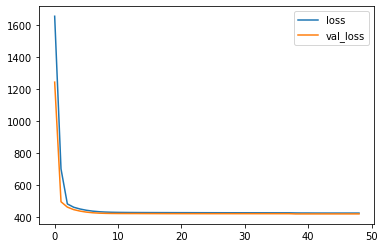

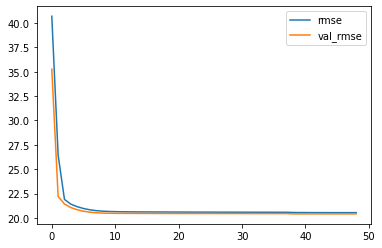

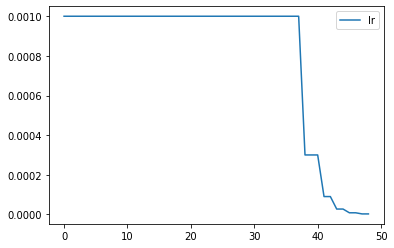

In [23]:
tf.keras.backend.clear_session()
models = []
historys = []
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
for index, (train_indices, val_indices) in enumerate(kfold.split(train)):
    if train_on_fold != None and train_on_fold != index:
        continue
    x_train = train.loc[train_indices, "file_path"]
    tabular_train = train.loc[train_indices, ["Pawpularity"] + tabular_columns]
    x_val= train.loc[val_indices, "file_path"]
    tabular_val = train.loc[val_indices, ["Pawpularity"] + tabular_columns]
    checkpoint_path = "model_%d.h5"%(index)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, 
        save_best_only=True
    )
    early_stop = tf.keras.callbacks.EarlyStopping(
        min_delta=1e-4, 
        patience=10
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.3,
        patience=2, 
        min_lr=1e-7
    )
    callbacks = [early_stop, checkpoint, reduce_lr]
    
    optimizer = tf.keras.optimizers.Adam(1e-3)
    
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, tabular_train)).map(preprocess_training).shuffle(512).batch(batch_size).cache().prefetch(AUTO)
    val_ds = tf.data.Dataset.from_tensor_slices((x_val, tabular_val)).map(preprocess_validation).batch(batch_size).cache().prefetch(AUTO)
    model = get_model()
    model.compile(
    loss = 'mse', 
    optimizer = 'Adam', 
    metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])
    history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)
    for metrics in [("loss", "val_loss"), ("rmse", "val_rmse"),["lr"]]:
        pd.DataFrame(history.history, columns=metrics).plot()
        plt.show()
    model.load_weights(checkpoint_path)
    historys.append(history)
    models.append(model)

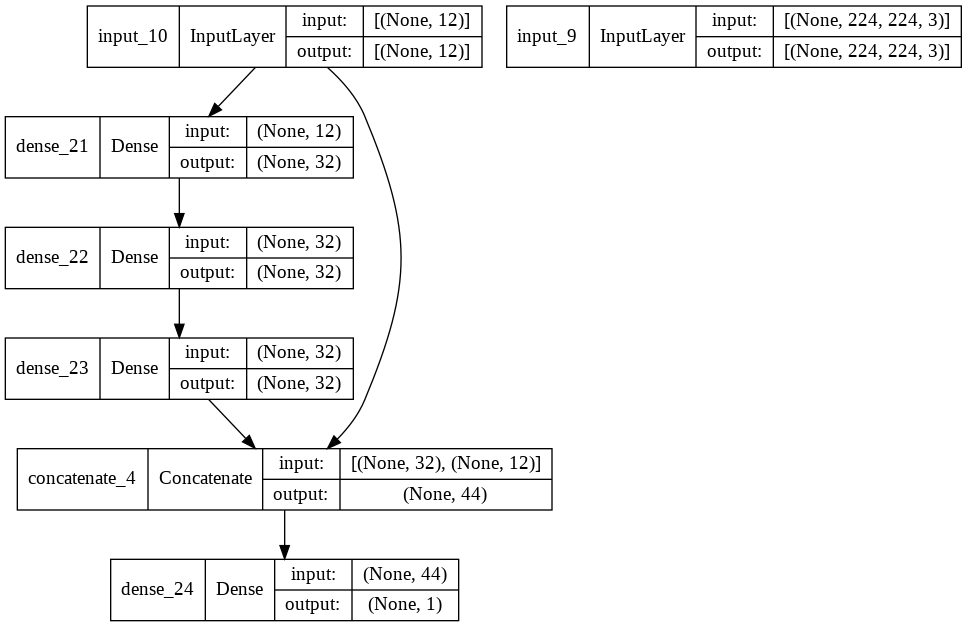

In [24]:
tf.keras.utils.plot_model(model, show_shapes=True)


In [25]:
def preprocess_test_data(image_url, tabular):
    print(image_url, tabular)
    image_string = tf.io.read_file(image_url)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.central_crop(image, 1.0)
    image = tf.image.resize(image, (image_size, image_size))
    # 0 won't be used in prediction, but it's needed in this senario or the tabular variable is treated as label.
    return (image, tabular), 0

In [26]:
test_ds = tf.data.Dataset.from_tensor_slices((test["file_path"], test[tabular_columns])).map(preprocess_test_data).batch(batch_size).cache().prefetch(2)

Tensor("args_0:0", shape=(), dtype=string) Tensor("args_1:0", shape=(12,), dtype=int64)


In [ ]:
total_results = []
for model in models:
    total_results.append(model.predict(test_ds).reshape(-1))
results = np.mean(total_results, axis=0).reshape(-1)
sample_submission["Pawpularity"] = results
sample_submission.to_csv("submission.csv", index=False)

In [ ]:
sample_submission.head(5)